<a href="https://colab.research.google.com/github/khal-drog0/Leaf_Disease_Image_Segmentation/blob/main/Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip3 install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle

! cp kaggle.json /root/.kaggle

! chmod 600 /root/.kaggle/kaggle.json

! kaggle competitions download -c cassava-leaf-disease-classification

! unzip cassava-leaf-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  inflating: train_images/3958304403.jpg  
  in

In [ ]:
import numpy as np
import pandas as pd
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image

# Importing data

In [ ]:
# Ref: https://www.kaggle.com/code/kirtichauhan11/cassava-disease-classification
train_df = pd.read_csv('train.csv')
train_df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


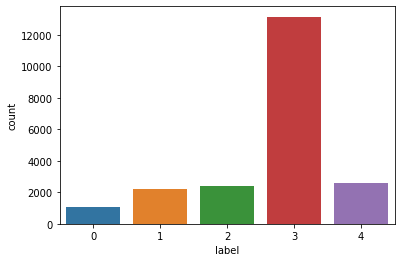

In [ ]:
import seaborn as sns
sns.countplot(train_df['label'])

In [ ]:
train_df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [ ]:
np.round((train_df['label'].value_counts()/len(train_df['label'])) * 100, 2)

3    61.49
4    12.04
2    11.15
1    10.23
0     5.08
Name: label, dtype: float64

In [ ]:
import json

with open('label_num_to_disease_map.json') as file:
    print(json.dumps(json.loads(file.read()), indent = 4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


# Exploratory data analysis

Class 0

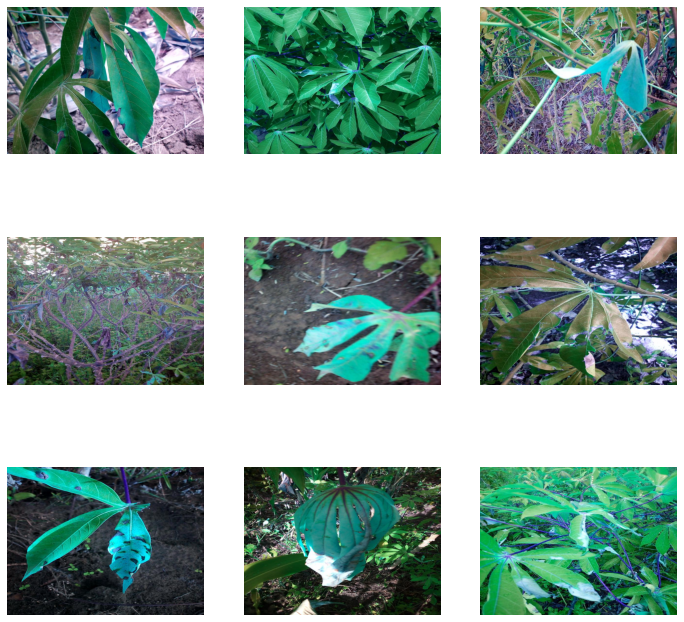

In [ ]:
import cv2
import matplotlib.pyplot as plt

sample = train_df[train_df.label == 0].sample(9)
plt.figure(figsize = (12, 12))

for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(3, 3, ind + 1)
    image = cv2.imread(os.path.join('train_images', image_id))
    plt.imshow(image)
    plt.axis('off')

plt.show()

Class 1

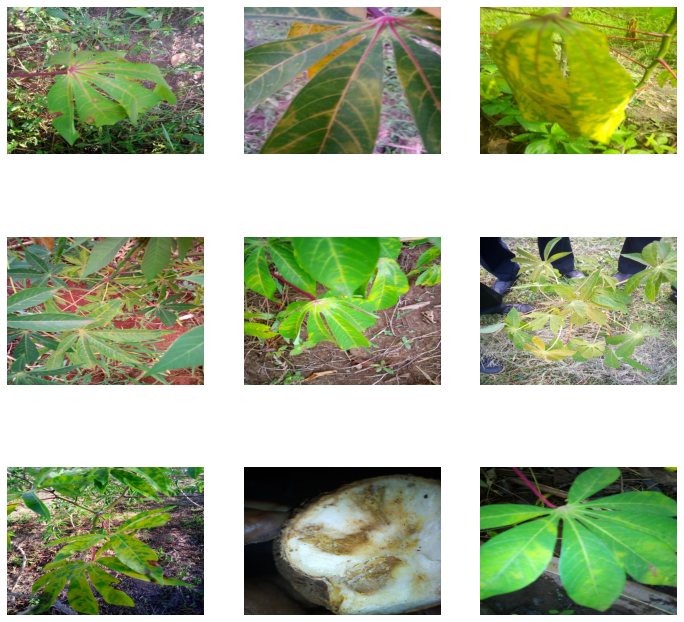

In [ ]:
sample = train_df[train_df.label == 1].sample(9)

plt.figure(figsize = (12, 12))

for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(3, 3, ind + 1)
    image = cv2.imread(os.path.join('train_images', image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.show()

Class 2

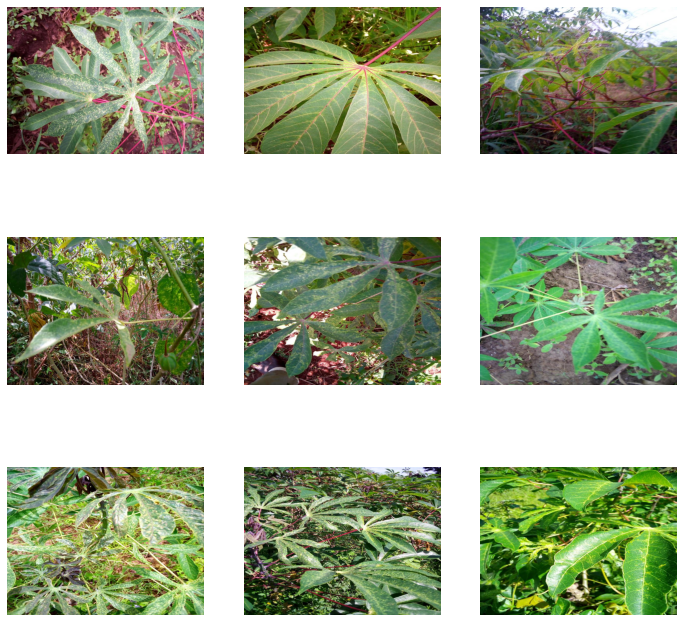

In [ ]:
sample = train_df[train_df.label == 2].sample(9)

plt.figure(figsize=(12,12))

for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(3, 3, ind + 1)
    image = cv2.imread(os.path.join("train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

Class 3

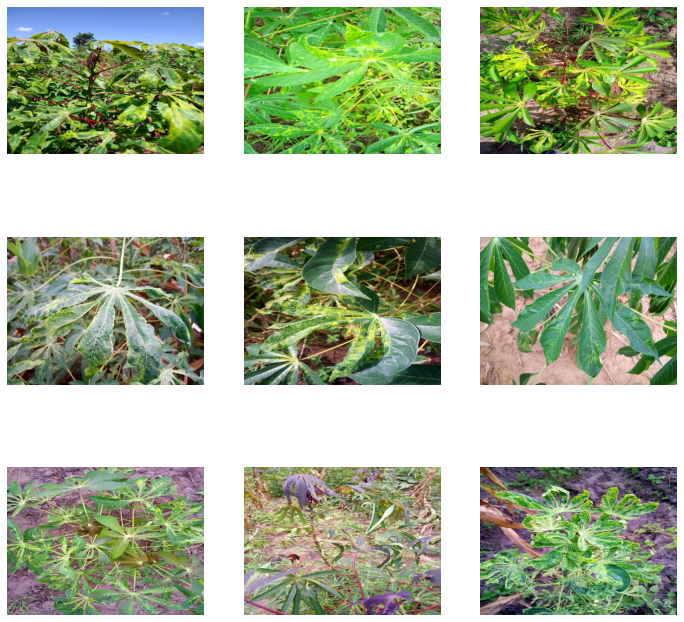

In [ ]:
sample = train_df[train_df.label == 3].sample(9)
plt.figure(figsize=(12,12))
for ind, (img_id, lab) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(3,3,ind+1)
    image = cv2.imread(os.path.join("train_images", img_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
plt.show()

Class 4

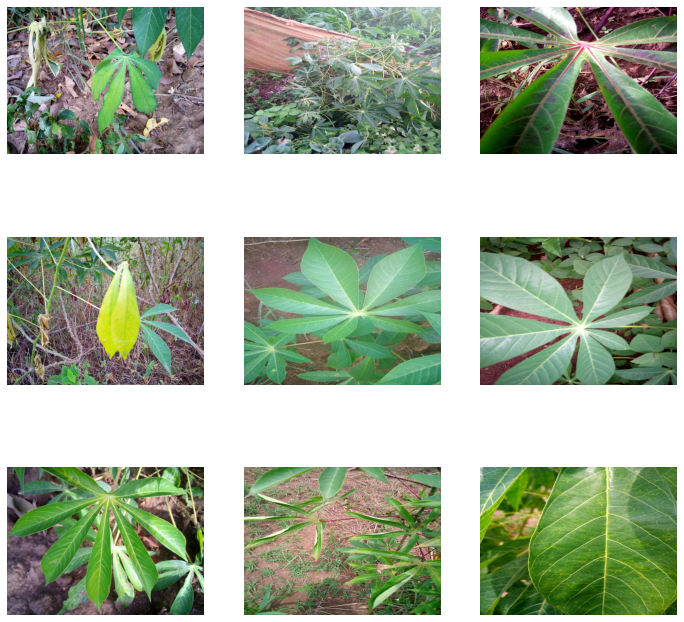

In [ ]:
sample = train_df[train_df.label == 4].sample(9)

plt.figure(figsize=(12,12))

for ind, (img_id, lab) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(3,3,ind+1)
    image = cv2.imread(os.path.join("train_images", img_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")

plt.show()

In [ ]:

from sklearn.metrics import accuracy_score

y_pred = [3] * len(train_df.label)
print("The baseline accuracy is {}".format(accuracy_score(y_pred, train_df.label)))

The baseline accuracy is 0.6149460204701593


This shows thate there are around 61% leaves of category 3 alone.

# Model

In [ ]:
b = 64 # Batch Size
img_size = 70

# Data Augmentation

In [ ]:
train_df['label'] = train_df['label'].astype('str')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2,
)

In [ ]:
# Generating training data

train_datagen = gen.flow_from_dataframe(
    train_df,
    directory = 'train_images',
    batch_size = b,
    target_size = (img_size, img_size),
    subset = 'training',
    seed = 42,
    x_col = 'image_id',
    y_col = 'label',
    class_mode = 'categorical'
)

Found 17118 validated image filenames belonging to 5 classes.


In [ ]:
val_gen = ImageDataGenerator(
    validation_split = 0.25
)

In [ ]:
# Generating validation data

val_datagen = val_gen.flow_from_dataframe(
    train_df,
    directory = 'train_images',
    batch_size = b,
    target_size = (img_size, img_size),
    subset = 'validation',
    seed = 42,
    x_col = 'image_id',
    y_col = 'label',
    class_mode = 'categorical'
)

Found 5349 validated image filenames belonging to 5 classes.


In [ ]:
len(train_datagen), len(val_datagen)

(268, 84)

In [ ]:
# Get the next batch of images and labels

img, label = next(train_datagen)

In [ ]:
label

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0.

In [ ]:
Steps_per_train = train_datagen.n / train_datagen.batch_size

Steps_per_val =  val_datagen.n / val_datagen.batch_size

In [ ]:
Steps_per_train, Steps_per_val

(267.46875, 83.578125)

# Transfer Learning

In [ ]:
import tensorflow as tf

from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import models, layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout

In [ ]:
newModel = models.Sequential([                       
        layers.Conv2D(256, kernel_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.Conv2D(256, kernel_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.MaxPool2D(pool_size = 2, strides = 2),

        layers.Conv2D(256, kernel_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.Conv2D(256, kernel_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.MaxPool2D(pool_size = 2, strides = 2),

        layers.BatchNormalization(),

        layers.Conv2D(128, kernel_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.Conv2D(128, kernel_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.MaxPool2D(pool_size = 2, strides = 2),

        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(1024, activation = 'relu'),

        layers.Dense(5, activation = 'softmax')
])

loss = tf.keras.losses.CategoricalCrossentropy(
        label_smoothing = 0.0001,
        name = 'categorical_crossentropy'
        )

newModel.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
              loss = loss,
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
newModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 68, 68, 256)       7168      
                                                                 
 conv2d_7 (Conv2D)           (None, 66, 66, 256)       590080    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 33, 33, 256)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 31, 31, 256)       590080    
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 256)       590080    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                  

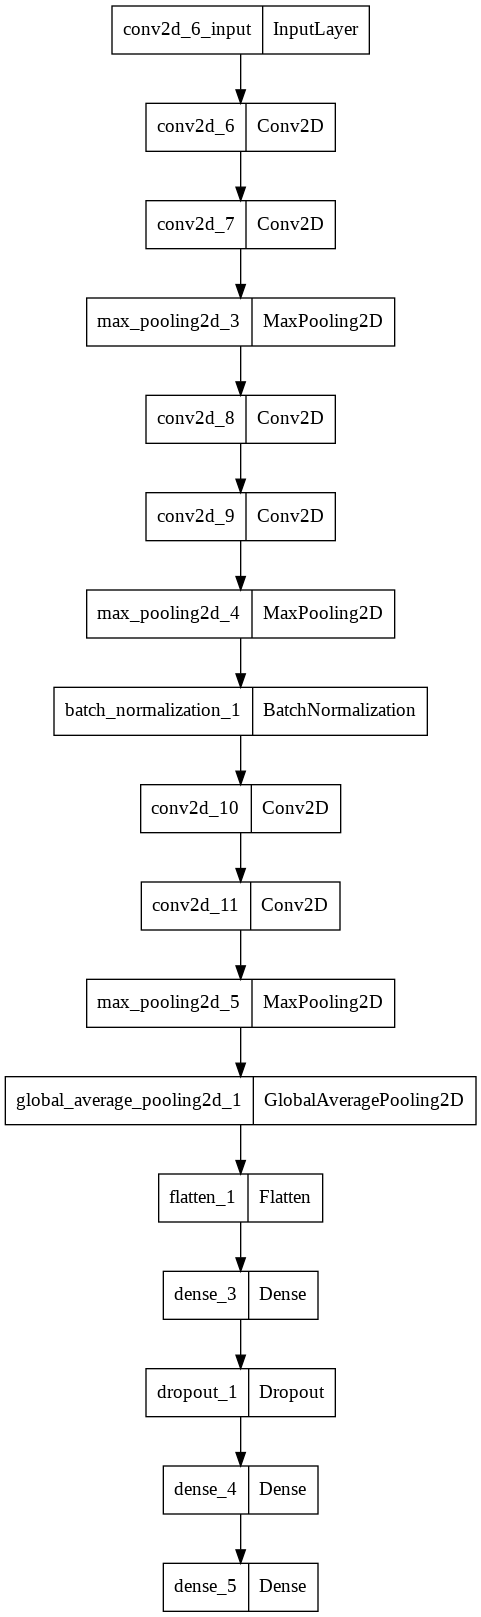

In [ ]:
tf.keras.utils.plot_model(newModel)

In [ ]:
new_history_1 = newModel.fit(train_datagen, epochs = 10, validation_data = val_datagen, batch_size = 64)

Epoch 1/10
268/268 [==============================] - 242s 898ms/step - loss: 1.0416 - accuracy: 0.6311 - val_loss: 0.9656 - val_accuracy: 0.6414
Epoch 2/10
268/268 [==============================] - 216s 807ms/step - loss: 0.9476 - accuracy: 0.6486 - val_loss: 1.2487 - val_accuracy: 0.5210
Epoch 3/10
268/268 [==============================] - 218s 812ms/step - loss: 0.8860 - accuracy: 0.6682 - val_loss: 0.8963 - val_accuracy: 0.6599
Epoch 4/10
268/268 [==============================] - 216s 807ms/step - loss: 0.8396 - accuracy: 0.6792 - val_loss: 0.9409 - val_accuracy: 0.6541
Epoch 5/10
268/268 [==============================] - 214s 798ms/step - loss: 0.8067 - accuracy: 0.6965 - val_loss: 0.8513 - val_accuracy: 0.6732
Epoch 6/10
154/268 [================>.............] - ETA: 1:11 - loss: 0.7773 - accuracy: 0.7040

In [ ]:
new_history_2 = newModel.fit(train_datagen, epochs = 10, validation_data = val_datagen, batch_size = 64)

In [ ]:
newModel.save('CustomCNN'+'.h5')

In [ ]:
# Reduce learing rate if the learning seems to have become constant

rlronp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    mode = 'min',
    min_lr = 1e-6,
    patience = 2,
    verbose = 1
    )

estop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    patience = 3, 
    verbose = 1,
    restore_best_weights = True
)

history_with_callbacks = newModel.fit(
    train_datagen,
    steps_per_epoch = Steps_per_train,
    epochs = 25,
    validation_data = val_datagen,
    validation_steps = Steps_per_val,
    callbacks = [rlronp, estop]
)

In [ ]:
newModel.save('EarlyStopping.h5')

In [ ]:
# def create_model():
#     model = models.Sequential([
#         EfficientNetB3(include_top = False, weights = 'imagenet', input_shape = (img_size, img_size, 3), drop_connect_rate = 0.3),
#         layers.GlobalAveragePooling2D(),
#         layers.Flatten(),
#         layers.Dense(256, activation = 'relu'),
#         layers.Dropout(0.3),
#         layers.Dense(5, activation = 'softmax')
#     ])

#     loss = tf.keras.losses.CategoricalCrossentropy(
#         label_smoothing = 0.0001,
#         name = 'categorical_crossentropy'
#         )

#     model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
#               loss = loss,
#               metrics = ['categorical_accuracy'])
#     return model

# model = create_model()
# model.summary()

43950080/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 3, 3, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 12

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


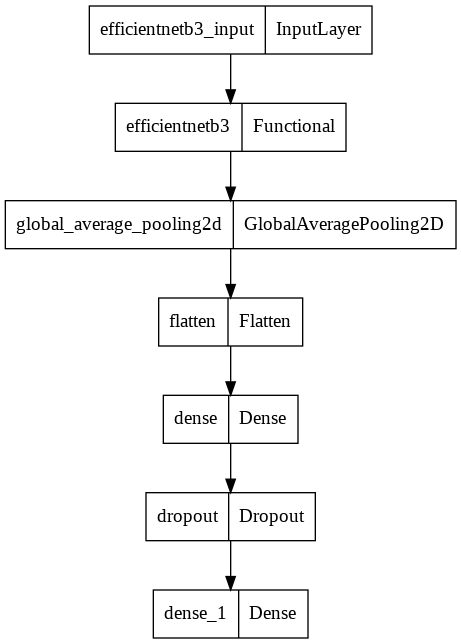

In [ ]:
# tf.keras.utils.plot_model(model)

In [ ]:
from glob import glob
data = glob('train_images/*.jpg', recursive = True)

In [ ]:
len(data)

21397

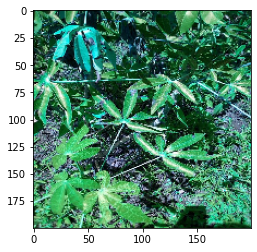

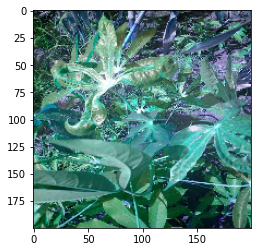

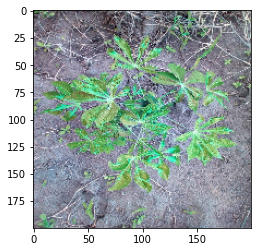

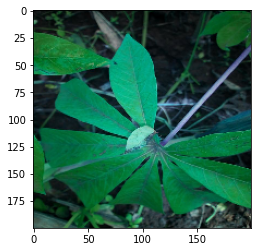

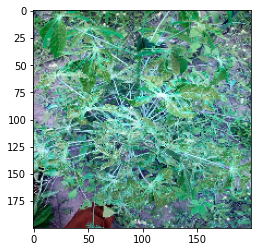

In [ ]:
import cv2
import matplotlib.pyplot as plt

for i in data[:5]:
    img = cv2.imread(i)
    img_1 = cv2.resize(img, (200, 200))
    plt.imshow(img_1, cmap = 'binary')
    plt.show()

In [ ]:
img_size = 70

In [ ]:
import cv2
import matplotlib.pyplot as plt

images = list()
labels = list()

for i in data:
    if i.endswith('.jpg'):
        label = i[-5]
        img = cv2.imread(i)
        img_1 = cv2.resize(img, (img_size, img_size))
        images.append(img_1)
        labels.append(label)

In [ ]:
len(images)

21397

In [ ]:
from numpy import array

a = array(images)
a.shape

(21397, 70, 70, 3)

In [ ]:
x = np.stack(images)

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels)

In [ ]:
x = x / 255

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, test_size = 0.25)

In [ ]:
print('len(x_train):', len(x_train))
print('len(x_test):', len(x_test))
print('len(y_train):', len(y_train))
print('len(y_test):', len(y_test))

len(x_train): 16047
len(x_test): 5350
len(y_train): 16047
len(y_test): 5350


In [ ]:
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

x_train (16047, 70, 70, 3)
x_test (5350, 70, 70, 3)
y_train (16047, 10)
y_test (5350, 10)


# Building the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, RepeatVector
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.regularizers import L2

def nn_model():
    model = models.Sequential([
                               
        # first convolution layer                       
        layers.Conv2D(32, filter_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.Conv2D(32, filter_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.MaxPool2D(pool_size = 2, strides = 2),

        # second convolution layer
        layers.Conv2D(32, filter_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.Conv2D(32, filter_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.MaxPool2D(pool_size = 2, strides = 2),

        layers.Conv2D(32, filter_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.Conv2D(32, filter_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
        layers.MaxPool2D(pool_size = 2, strides = 2),



    ])

    return model

model = nn_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 global_average_pooling2d_1   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               655616    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                      

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr = 0.00001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad =  False)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training the Model

In [ ]:
history = model.fit(x, y, epochs = 25, validation_split = 0.4, batch_size = 64)

Epoch 1/25
201/201 [==============================] - 304s 1s/step - loss: 2.3555 - accuracy: 0.1026 - val_loss: 2.3172 - val_accuracy: 0.1023
Epoch 2/25
201/201 [==============================] - 247s 1s/step - loss: 2.3253 - accuracy: 0.1096 - val_loss: 2.3313 - val_accuracy: 0.1040
Epoch 3/25
201/201 [==============================] - 247s 1s/step - loss: 2.2997 - accuracy: 0.1256 - val_loss: 2.3240 - val_accuracy: 0.1033
Epoch 4/25
201/201 [==============================] - 246s 1s/step - loss: 2.2850 - accuracy: 0.1325 - val_loss: 2.3233 - val_accuracy: 0.0988
Epoch 5/25
201/201 [==============================] - 248s 1s/step - loss: 2.2718 - accuracy: 0.1429 - val_loss: 2.3245 - val_accuracy: 0.0944
Epoch 6/25
201/201 [==============================] - 247s 1s/step - loss: 2.2528 - accuracy: 0.1627 - val_loss: 2.3257 - val_accuracy: 0.0964
Epoch 7/25
201/201 [==============================] - 247s 1s/step - loss: 2.2384 - accuracy: 0.1739 - val_loss: 2.3298 - val_accuracy: 0.0977

# Evaluating the model

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

168/168 [==============================] - 31s 177ms/step - loss: 1.4524 - accuracy: 0.6120


In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_data', 'test_data'])
plt.title('Loss Analysis')
plt.show()

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data', 'test_data'])
plt.title('Accuracy Analysis')
plt.show()